### Test case LVV-T67: Verify implementation of Object Catalog

Verify that the DRP pipelines produce an Object catalog derived from detections made on both coadded images and difference images and measurements performed on coadds and possibly overlapping single-epoch images.

**DMS-REQ-0275** Specification: The DMS shall create an Object Catalog, based on deblended sources detected in coadds and knowledge of DIASource, DIAObject, and SSObject Catalogs, after multi-epoch spatial association and characterization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

In [2]:
butler = Butler('dp2_prep', collections="LSSTCam/runs/DRP/20250515-20251214/v30_0_0_rc2/DM-53697")

#### Retrieve an object catalog:

Select a single `object` catalog at a (randomly-selected) RA, Dec position. Limit the query results to return only one dataset reference.

In [3]:
ra = 187.8881321
dec = 8.9682481
obj_refs = butler.query_datasets('object', 
                                 where="patch.region OVERLAPS POINT(ra, dec)",
                                 bind={"ra":ra, "dec":dec},
                                 skymap='lsst_cells_v2', limit=1)

In [4]:
obj_refs

[DatasetRef(DatasetType('object', {skymap, tract}, ArrowAstropy), {skymap: 'lsst_cells_v2', tract: 10804}, run='LSSTCam/runs/DRP/20250515-20251214/v30_0_0_rc2/DM-53697/20251227T193146Z', id=019b6166-1667-7220-b088-1c395603fad5)]

In [5]:
obj = butler.get(obj_refs[0],
                 parameters={'columns': ['objectId', 'coord_ra', 'coord_dec', 'patch', 'tract',
                                         'deblend_blendNChild', 'deblend_parentNPeaks',
                                         'footprintArea', 'i_pixelFlags_interpolated',
                                         'g_sersicFlux', 'g_sersicFluxErr',
                                         'i_ixx', 'i_ixy', 'i_iyy',
                                         'refExtendedness', 'refSizeExtendedness',
                                         'g_psfFlux', 'g_psfFluxErr', 'ebv',
                                         'r_psfFlux', 'r_psfFluxErr',
                                         'i_psfFlux', 'i_psfFluxErr',
                                         'g_inputCount', 'r_inputCount', 'i_inputCount']},
                 storageClass='DataFrame')

len(obj)

785249

In [6]:
patch_to_pick = 42
pick_patch = (obj['patch'] == patch_to_pick)
obj[pick_patch]

,objectId,coord_ra,coord_dec,patch,tract,deblend_blendNChild,deblend_parentNPeaks,footprintArea,i_pixelFlags_interpolated,g_sersicFlux,...,g_psfFlux,g_psfFluxErr,ebv,r_psfFlux,r_psfFluxErr,i_psfFlux,i_psfFluxErr,g_inputCount,r_inputCount,i_inputCount
319812,74247408883597465,187.987642,8.015101,42,10804,0,0,1636,True,5686.138184,...,2948.006104,13.303143,0.018942,4962.969238,17.576403,6514.305664,30.192974,86,126,83
319813,74247408883597470,187.845447,8.015277,42,10804,0,0,770,False,431.939056,...,416.656647,15.525067,0.020577,1261.299927,19.102827,1966.890015,36.282959,57,94,52
319814,74247408883597478,187.939340,8.015352,42,10804,0,0,640,False,557.949036,...,449.893311,12.244299,0.019117,585.788696,16.575336,904.355896,27.928385,89,135,85
319815,74247408883597479,187.885818,8.015806,42,10804,0,0,1860,False,5178.346680,...,2083.084229,13.967111,0.019738,2966.222412,17.753513,3494.229736,30.636641,79,118,79
319816,74247408883597482,187.946068,8.015199,42,10804,0,0,139,False,26.127403,...,10.149603,12.575442,0.019107,44.821014,16.202595,139.088715,27.705965,89,127,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330078,74247408883627960,187.882876,8.149646,42,10804,1,2,337,False,116.553192,...,69.031441,14.135236,0.022923,69.391594,17.603767,107.145355,30.849527,69,104,66
330079,74247408883627961,187.925631,8.153226,42,10804,1,2,388,False,19.480259,...,19.505453,13.478311,0.022818,59.069180,16.956755,7.069619,30.023895,76,122,70
330080,74247408883627962,187.926245,8.153207,42,10804,1,2,402,False,162.953125,...,82.796227,13.530655,0.022821,74.902733,16.944992,60.005619,30.019936,76,123,70
330081,74247408883627963,187.894922,8.168454,42,10804,1,2,283,False,103.277916,...,74.998314,14.067284,0.022629,33.509212,17.791023,55.047970,32.143208,72,104,64


Retrieve a coadd image for one patch:

In [7]:
data_id = {'tract':obj_refs[0].dataId['tract'],
           'band':'r', 'patch':patch_to_pick,
           'skymap':obj_refs[0].dataId['skymap']}

coadd = butler.get('deep_coadd', dataId=data_id)

Calculate XY coordinates, then subselect objects in a small region of the image.

In [8]:
x, y = coadd.wcs.skyToPixelArray(obj[pick_patch]['coord_ra'], obj[pick_patch]['coord_dec'], degrees=True)

tx = np.where((x < 6900) & (x > 6500) & (y < 13900) & (y > 13500))[0]

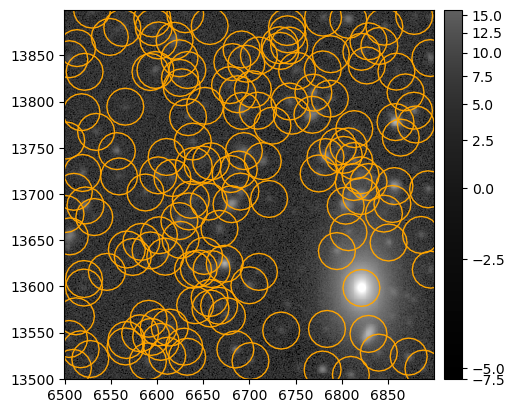

In [9]:
afwDisplay.setDefaultBackend('matplotlib')
afw_display = afwDisplay.Display(frame=1)
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd[6500:6900, 13500:13900])

with afw_display.Buffering():
    for i in tx:
        afw_display.dot('o', x[i], y[i],
                        size=20, ctype='orange')

## Results

We have demonstrated that the Science Pipelines produce `Object` tables based on deblended sources from coadd images. We have examined a subset of the columns from the `Object` table, and used them to overlay detected source positions on the coadd image, demonstrating that objects with overlapping footprints have been deblended. Thus, we deem the result of this test a **Pass**.